# ECG - Arrythmia Classification - (Physionet - MIT-BIH )

In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

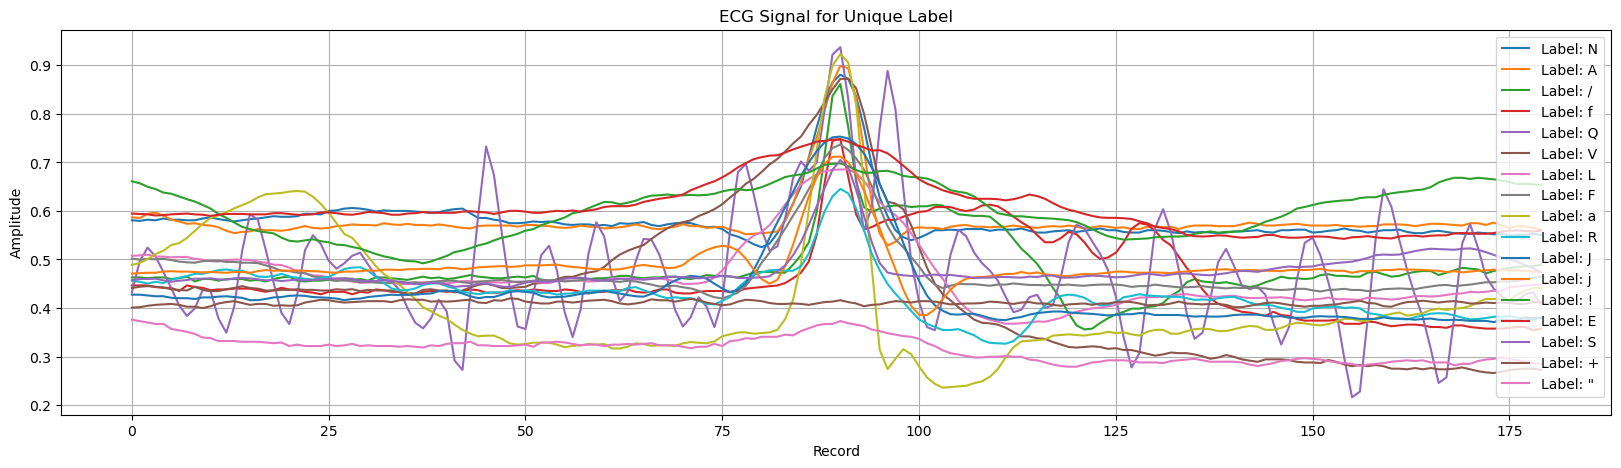

In [3]:
# File extensions for data and annotations
dat_file_extension = 'dat'
atr_file_extension = 'atr'

# Create a dictionary to collect one example from each unique label
unique_labels_examples = {}
total_heatbeats = 0
total_labels = 0
total_rpeaks = 0
# Loop through each record file in the specified range
for record_number in [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                             111, 112, 113, 114, 115, 116, 117, 118, 119,
                             121, 122, 123, 124,
                             200, 201, 202, 203, 205, 207, 208, 209, 210,
                             212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]:

    record_name = str(record_number)

    try:
        # Load ECG data from the .dat file
        ecg_data, _ = wfdb.rdsamp(record_name, sampfrom=0, channels=[0])

        # Load annotations from the .atr file
        annotation = wfdb.rdann(record_name, atr_file_extension)

        # Normalize the ECG signal to the range [0, 1]
        ecg_data = (ecg_data - np.min(ecg_data)) / (np.max(ecg_data) - np.min(ecg_data))

        # Find R-peaks in the ECG signal
        r_peaks, _ = find_peaks(ecg_data[:, 0], height=0.2, distance=200)

        # Extract heartbeats
        heartbeat_length = 180
        heartbeats = []
        labels = []
        total_rpeaks = total_rpeaks + len(r_peaks)
        
        for r_peak in r_peaks:
            # Determine the annotation label for the current R-peak
            annotation_indices = np.where(annotation.sample == r_peak)[0]

            if annotation_indices.size > 0:
                # Use the first matching annotation index
                annotation_index = annotation_indices[0]
                label = annotation.symbol[annotation_index]

                # Extract a heartbeat centered around the R-peak
                start = r_peak - heartbeat_length // 2
                end = r_peak + heartbeat_length // 2
                if start < 0 or end >= len(ecg_data):
                    continue

                heartbeat = ecg_data[start:end, 0]
    
                # Resize the heartbeat to a fixed length (280 samples)
                interpolation_function = interp1d(
                    np.arange(len(heartbeat)),
                    heartbeat,
                    kind='linear',
                    fill_value='extrapolate'
                )
                resized_heartbeat = interpolation_function(np.linspace(0, len(heartbeat) - 1, heartbeat_length))

                heartbeats.append(resized_heartbeat)
                labels.append(label)
                total_heatbeats = total_heatbeats + len(heartbeats)
                total_labels = total_labels + len(labels)
                
        # Collect one example from each unique label
        for i in range(len(heartbeats)):
            label = labels[i]
            if label not in unique_labels_examples:
                unique_labels_examples[label] = heartbeats[i]

    except FileNotFoundError:
        # Handle the case where the file does not exist
        print(f"File '{record_name}' not found. Skipping...")

# Plot one example from each unique label
plt.figure(figsize=(20, 5))
for label, heartbeat in unique_labels_examples.items():
    plt.plot(heartbeat, label=f'Label: {label}')

plt.xlabel('Record')
plt.ylabel('Amplitude')
plt.title('ECG Signal for Unique Label')
plt.legend()
plt.grid(True)
plt.show()

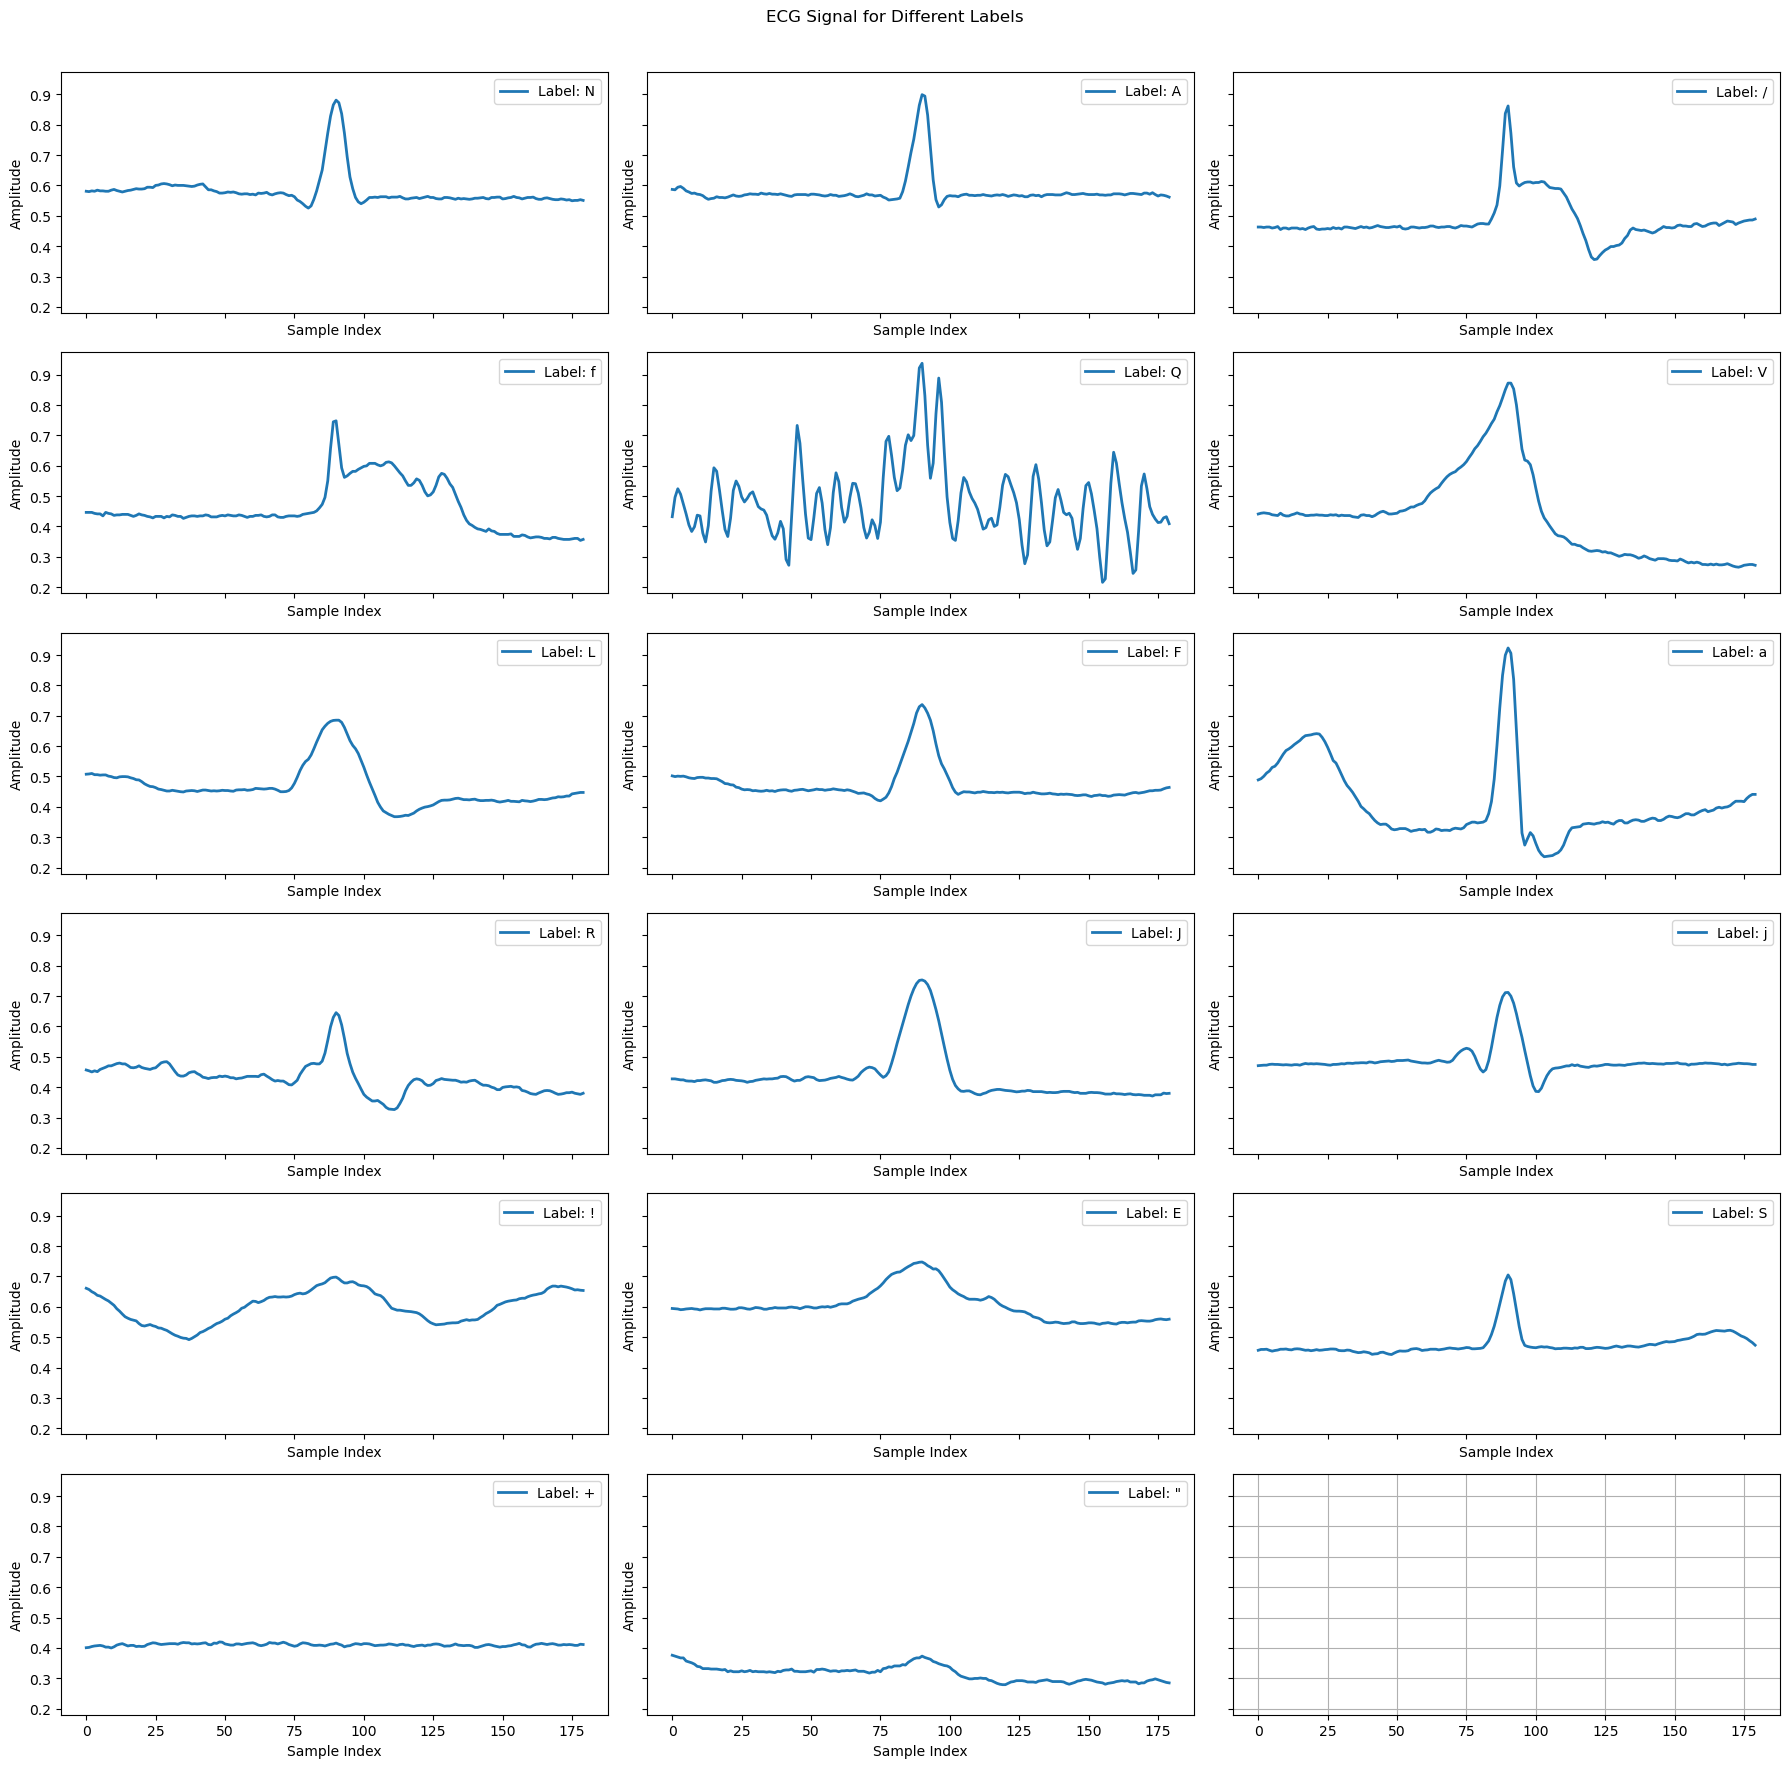

In [4]:
# Plot heartbeats for each label separately
fig, axs = plt.subplots(len(unique_labels_examples) // 3 + 1, 3, figsize=(18, 3 * (len(unique_labels_examples) // 3 + 1)), sharex=True, sharey=True)

for i, (label, heartbeat) in enumerate(unique_labels_examples.items()):
    row = i // 3
    col = i % 3
    axs[row, col].plot(heartbeat, label=f'Label: {label}', linewidth=2)  # Increase linewidth
    axs[row, col].set_xlabel('Sample Index')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].legend()

plt.suptitle('ECG Signal for Different Labels')
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout for title
plt.grid(True)
plt.show()

In [5]:
total_rpeaks

113024

In [6]:
unique_labels = list(set(labels))

for label, heartbeat in unique_labels_examples.items():
    print(label)

N
A
/
f
Q
V
L
F
a
R
J
j
!
E
S
+
"


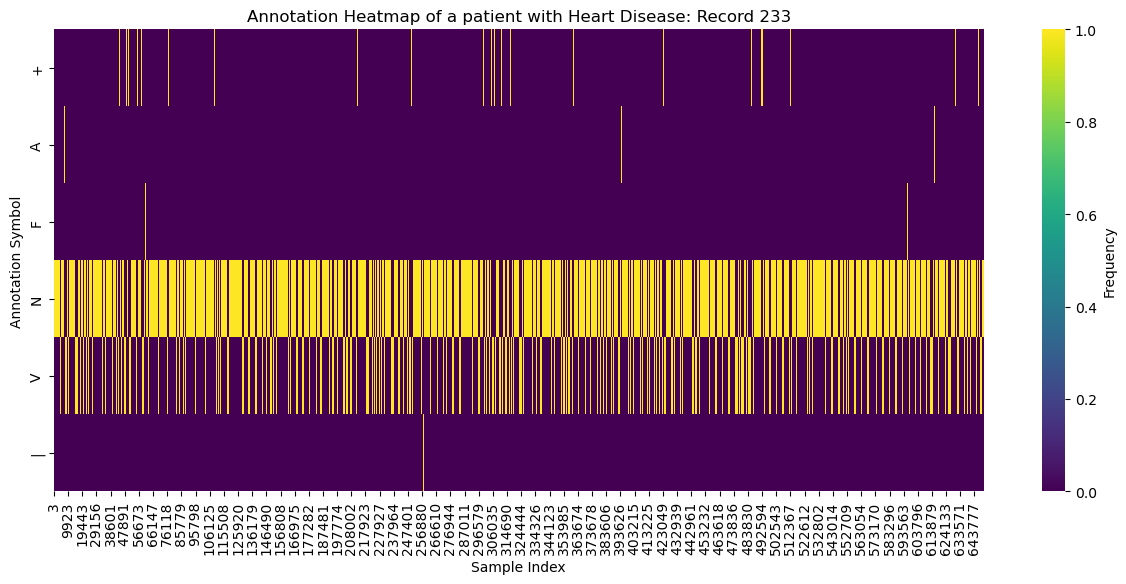

In [7]:
record = wfdb.rdrecord('233')
ecg_data = record.p_signal[:, 0]
annotation = wfdb.rdann('233', atr_file_extension)

annotation_df = pd.DataFrame({'Sample': annotation.sample, 'Symbol': annotation.symbol})

# Create a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(annotation_df.pivot_table(index='Symbol', columns='Sample', aggfunc='size', fill_value=0),
            cmap='viridis', cbar_kws={'label': 'Frequency'})
plt.title('Annotation Heatmap of a patient with Heart Disease: Record 233')
plt.xlabel('Sample Index')
plt.ylabel('Annotation Symbol')
plt.show()

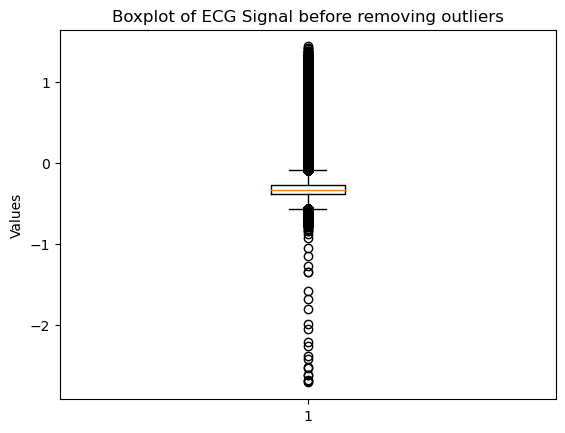

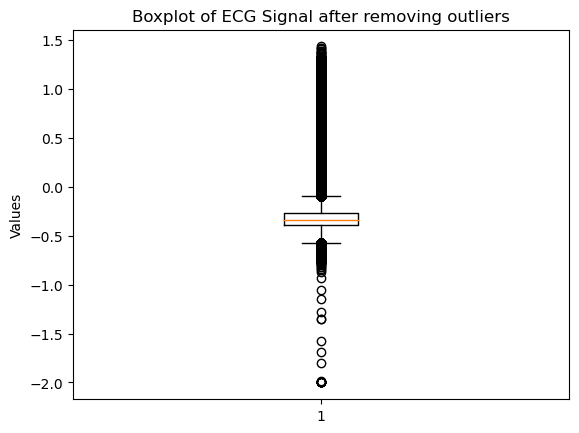

In [8]:
record = wfdb.rdrecord('100')
ecg_data = record.p_signal[:, 0]

plt.boxplot(ecg_data)
plt.title("Boxplot of ECG Signal before removing outliers")
plt.ylabel("Values")
plt.show()

ecg_data = np.clip(ecg_data, -2, 2)

plt.boxplot(ecg_data)
plt.title("Boxplot of ECG Signal after removing outliers")
plt.ylabel("Values")
plt.show()

# Data Cleaning and transformation

In [2]:
# File extensions for data and annotations
dat_file_extension = 'dat'
atr_file_extension = 'atr'

heartbeats = []
labels = []

total_rpeaks = 0
total_heatbeats = 0
total_labels = 0 

def clean_data(data):
    # Remove outliers
    data = np.clip(data, -10, 10)

    # Correct baseline wander
    data = data - np.mean(data)
    
    return data

def normalize_data(data):

    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    
    return data


for record_number in [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                             111, 112, 113, 114, 115, 116, 117, 118, 119,
                             121, 122, 123, 124,
                             200, 201, 202, 203, 205, 207, 208, 209, 210,
                             212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]:

    record_name = str(record_number)

    try:
        # Load ECG data from the .dat file
        record = wfdb.rdrecord(record_name)
        ecg_data = record.p_signal[:, 0]
        
        
        # Load annotations from the .atr file
        annotation = wfdb.rdann(record_name, atr_file_extension)
        
        #clean ECG data
        ecg_data = clean_data(ecg_data)
        

        # Normalize the ECG signal to the range [0, 1]
        ecg_data = normalize_data(ecg_data)

        # Find R-peaks in the ECG signal
        r_peaks, _ = find_peaks(ecg_data, height=0.2, distance=200)
        
        for r_peak in r_peaks:
            total_rpeaks = total_rpeaks + 1
            # Determine the annotation label for the current R-peak
            annotation_indices = np.where(annotation.sample == r_peak)[0]
            
            if annotation_indices.size > 0:
                # Use the first matching annotation index
                annotation_index = annotation_indices[0]
                annotation_label = annotation.symbol[annotation_index]

                
            start = r_peak - 100  # Adjust the window size as needed
            end = r_peak + 100    # Adjust the window size as needed
            if start < 0 or end >= len(ecg_data):
                continue
                    
            heartbeat_segment = ecg_data[start:end]
            heartbeats.append(heartbeat_segment)
            labels.append(annotation_label)
                
            total_heatbeats = total_heatbeats + 1
            total_labels = total_labels + 1
           
        
        aami_categories = {'N': [], 'S': [], 'V': [], 'F': [], 'Q': []}
       
        for i in range(len(heartbeats)):
            annotation_l = labels[i]
            heartbeat = heartbeats[i]
            
            if annotation_l in ['N', 'L', 'R', 'e', 'j']:
                aami_categories['N'].append(heartbeat)

            elif annotation_l in ['V', 'E']:
                aami_categories['V'].append(heartbeat)

            elif annotation_l in ['A', 'a', 'J', 'S']:
                aami_categories['S'].append(heartbeat)

            elif annotation_l == 'F':
                aami_categories['F'].append(heartbeat)

            elif annotation_l in ['P', '/', 'f', 'Q', 'U']:
                aami_categories['Q'].append(heartbeat)

            else:
                continue
        
    except FileNotFoundError:
        # Handle the case where the file does not exist
        print(f"File '{record_name}' not found. Skipping...")


In [3]:
# Loop through the AAMI categories and print the counts
total = 0
for category, heartbeats in aami_categories.items():
    count = len(heartbeats)
    print(f'Category {category}: {count} heartbeats')
    total = total + count
    
print(f'Total segments from all Category {total}')


Category N: 95696 heartbeats
Category S: 2486 heartbeats
Category V: 8347 heartbeats
Category F: 512 heartbeats
Category Q: 4294 heartbeats
Total segments from all Category 111335


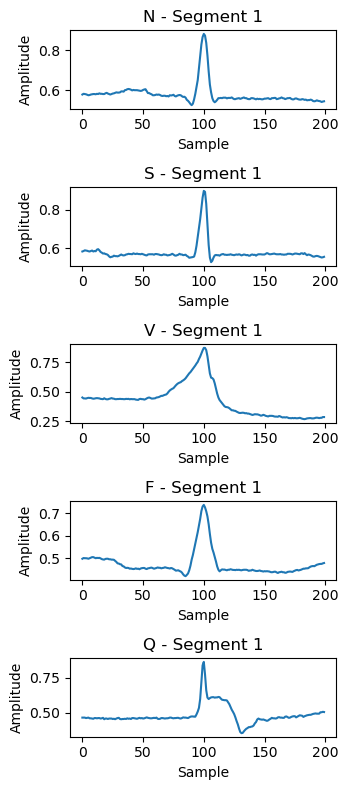

AAMI Class Type: N, Number of Segments: 95696
AAMI Class Type: S, Number of Segments: 2486
AAMI Class Type: V, Number of Segments: 8347
AAMI Class Type: F, Number of Segments: 512
AAMI Class Type: Q, Number of Segments: 4294


In [11]:
# Define a dictionary to count the number of segments for each annotation type
num_segments_per_category = {}

# Create a single figure for all annotation types
plt.figure(figsize=(15, 8))

# Visualize each type of annotation
for i, (aami_label, segments) in enumerate(aami_categories.items()):
    num_segments = len(segments)
    num_segments_per_category[aami_label] = num_segments

    for j, segment in enumerate(segments[:1]): 
        plt.subplot(5, len(aami_categories), i * 5 + j + 1)
        plt.plot(segment)
        plt.title(f'{aami_label} - Segment {j + 1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

# Print the number of segments for each annotation type
for aami_label, num_segments in num_segments_per_category.items():
    if(aami_label == 'S'):
        num_seg_s = num_segments
    elif(aami_label == 'F'):
        num_seg_f = num_segments
    elif(aami_label == 'N'):
        num_seg_n = num_segments
    elif(aami_label == 'V'):
        num_seg_v = num_segments
    elif(aami_label == 'Q'):
        num_seg_q = num_segments
    
    print(f'AAMI Class Type: {aami_label}, Number of Segments: {num_segments}')

# Data sampling to balance data using oversampling

In [5]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X = []  # Features
y = []  # Target variable

for category, heartbeats in aami_categories.items():
    if heartbeats:
        # Append the features and labels
        X.extend(heartbeats)
        y.extend([category] * len(heartbeats))

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [23]:
df = pd.DataFrame(data=X, columns=[f'value{i}' for i in range(1, X.shape[1] + 1)])
df['label'] = y

# Save the entire dataset to a CSV file
df.to_csv('final.csv', index=False)

In [45]:
# Set the desired number of samples for S and F
desired_samples_S = 3*num_seg_s  
desired_samples_F = 3*num_seg_f  

# Create a dictionary with the desired number of samples for each class
sampling_strategy = {'F': desired_samples_F, 'S': desired_samples_S}

# Use RandomOverSampler to oversample the minority classes (F and S) in the entire dataset
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# Fit and transform the dataset
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Check the number of samples for S and F after resampling
Total = num_seg_n + sum(y_resampled == 'S') + num_seg_v + num_seg_q + sum(y_resampled == 'F')

print("Total Number of samples after oversampling minority class:", Total)
print()
print("Number of samples for 'N' after oversampling minority class:", num_seg_n)
print("Number of samples for 'S' after oversampling minority class:", sum(y_resampled == 'S'))
print("Number of samples for 'V' after oversampling minority class:", num_seg_v)
print("Number of samples for 'F' after oversampling minority class:", sum(y_resampled == 'F'))
print("Number of samples for 'Q' after oversampling minority class:", num_seg_q)


Total Number of samples after oversampling minority class: 117331

Number of samples for 'N' after oversampling minority class: 95696
Number of samples for 'S' after oversampling minority class: 7458
Number of samples for 'V' after oversampling minority class: 8347
Number of samples for 'F' after oversampling minority class: 1536
Number of samples for 'Q' after oversampling minority class: 4294


In [46]:
df = pd.DataFrame(data=X_resampled, columns=[f'value{i}' for i in range(1, X_resampled.shape[1] + 1)])
df['label'] = y_resampled

# Save the entire dataset to a CSV file
df.to_csv('final_randomoversampling.csv', index=False)

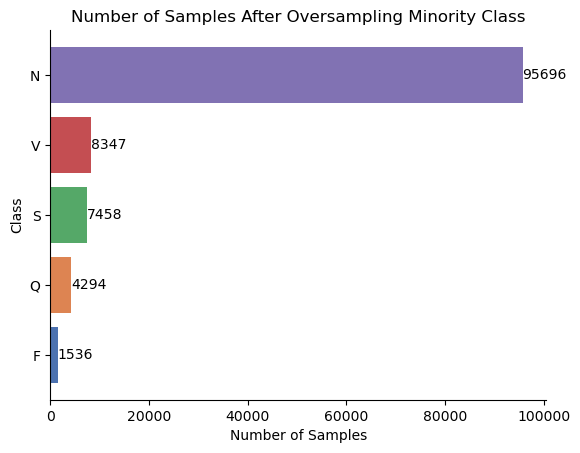

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the variables defined as follows
Total = num_seg_n + sum(y_resampled == 'S') + num_seg_v + num_seg_q + sum(y_resampled == 'F')
num_samples = [num_seg_n, sum(y_resampled == 'S'), num_seg_v, num_seg_q, sum(y_resampled == 'F')]
class_labels = ['N', 'S', 'V', 'Q', 'F']

# Sort class labels and corresponding samples in descending order
sorted_data = sorted(zip(class_labels, num_samples), key=lambda x: x[1], reverse=False)
class_labels_sorted, num_samples_sorted = zip(*sorted_data)

# Define a custom color palette
colors = sns.color_palette("deep")

# Plotting the horizontal bar chart with the sorted data and custom color palette
plt.barh(class_labels_sorted, num_samples_sorted, color=colors)
plt.xlabel('Number of Samples')
plt.ylabel('Class')
plt.title('Number of Samples After Oversampling Minority Class')

# Displaying the number of samples in front of each bar with increased boundaries
for index, value in enumerate(num_samples_sorted):
    plt.text(value + 5, index, str(value), ha='left', va='center')

# Remove spines (borders) from the plot
sns.despine()

plt.show()


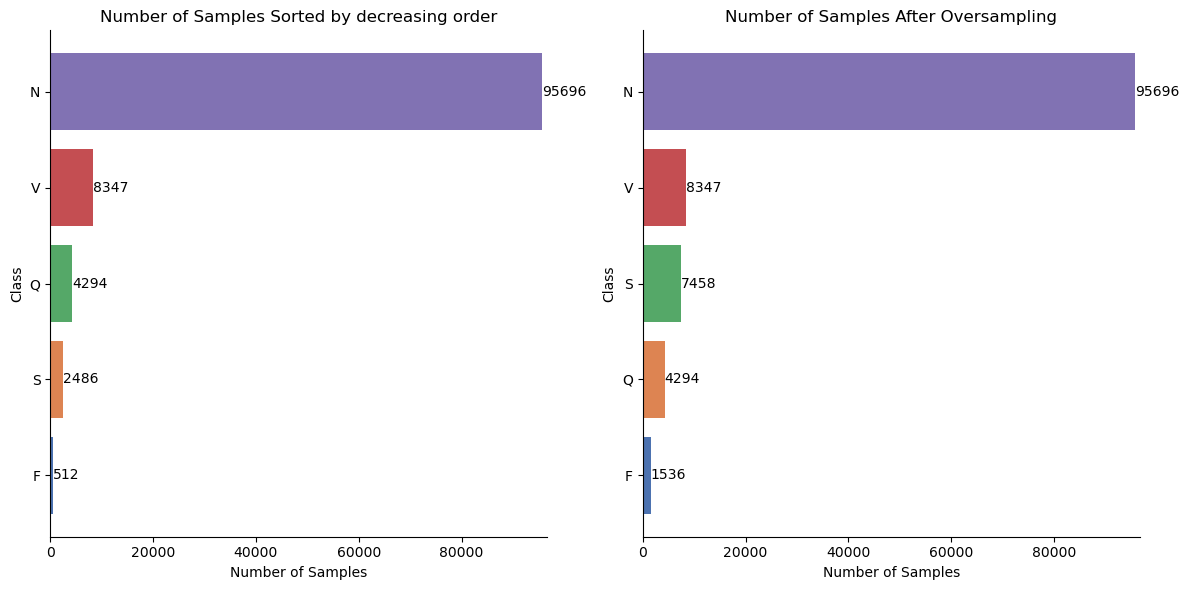

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the variables defined as follows
num_seg_n_before = 95696
num_seg_s_before = 2486
num_seg_v_before = 8347
num_seg_f_before = 512
num_seg_q_before = 4294

num_samples_before = [num_seg_n_before, num_seg_s_before, num_seg_v_before, num_seg_q_before, num_seg_f_before]

num_seg_n_after = 95696
num_seg_s_after = 7458
num_seg_v_after = 8347
num_seg_f_after = 1536
num_seg_q_after = 4294

num_samples_after = [num_seg_n_after, num_seg_s_after, num_seg_v_after, num_seg_q_after, num_seg_f_after]

class_labels = ['N', 'S', 'V', 'Q', 'F']

# Sort class labels and corresponding samples in descending order
sorted_data_before = sorted(zip(class_labels, num_samples_before), key=lambda x: x[1], reverse=False)
class_labels_sorted_before, num_samples_sorted_before = zip(*sorted_data_before)

sorted_data_after = sorted(zip(class_labels, num_samples_after), key=lambda x: x[1], reverse=False)
class_labels_sorted_after, num_samples_sorted_after = zip(*sorted_data_after)

# Define a custom color palette
colors = sns.color_palette("deep")

# Plotting the horizontal bar chart with the sorted data and custom color palette
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotting before oversampling
axes[0].barh(class_labels_sorted_before, num_samples_sorted_before, color=colors)
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Class')
axes[0].set_title('Number of Samples Sorted by decreasing order')
axes[0].set_xlim([0, max(num_samples_before) + 1000])

# Displaying the number of samples in front of each bar with increased boundaries
for index, value in enumerate(num_samples_sorted_before):
    axes[0].text(value + 5, index, str(value), ha='left', va='center')

# Plotting after oversampling
axes[1].barh(class_labels_sorted_after, num_samples_sorted_after, color=colors)
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Class')
axes[1].set_title('Number of Samples After Oversampling')
axes[1].set_xlim([0, max(num_samples_after) + 1000])

# Displaying the number of samples in front of each bar with increased boundaries
for index, value in enumerate(num_samples_sorted_after):
    axes[1].text(value + 5, index, str(value), ha='left', va='center')

# Remove spines (borders) from the plots
sns.despine()

plt.tight_layout()
plt.show()


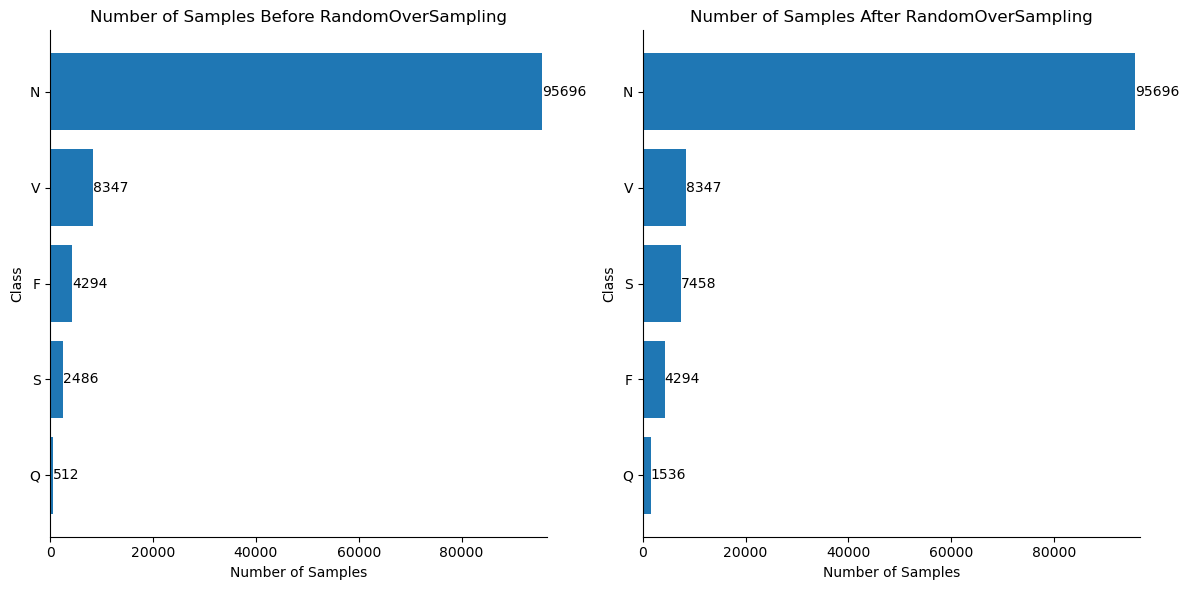

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the variables defined as follows
num_seg_n_before = 95696
num_seg_s_before = 2486
num_seg_v_before = 8347
num_seg_f_before = 512
num_seg_q_before = 4294

num_samples_before = [num_seg_n_before, num_seg_s_before, num_seg_v_before, num_seg_q_before, num_seg_f_before]

num_seg_n_after = 95696
num_seg_s_after = 7458
num_seg_v_after = 8347
num_seg_f_after = 1536
num_seg_q_after = 4294

num_samples_after = [num_seg_n_after, num_seg_s_after, num_seg_v_after, num_seg_q_after, num_seg_f_after]

# Modify the order of class labels
class_labels = ['N', 'S', 'V', 'F', 'Q']

# Sort class labels and corresponding samples in descending order
sorted_data_before = sorted(zip(class_labels, num_samples_before), key=lambda x: x[1], reverse=False)
class_labels_sorted_before, num_samples_sorted_before = zip(*sorted_data_before)

sorted_data_after = sorted(zip(class_labels, num_samples_after), key=lambda x: x[1], reverse=False)
class_labels_sorted_after, num_samples_sorted_after = zip(*sorted_data_after)

# Define a custom color palette
colors = sns.color_palette("deep")

# Plotting the horizontal bar chart with the sorted data and custom color palette
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotting before oversampling
axes[0].barh(class_labels_sorted_before, num_samples_sorted_before)
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Class')
axes[0].set_title('Number of Samples Before RandomOverSampling')
axes[0].set_xlim([0, max(num_samples_before) + 1000])

# Displaying the number of samples in front of each bar with increased boundaries
for index, value in enumerate(num_samples_sorted_before):
    axes[0].text(value + 5, index, str(value), ha='left', va='center')

# Plotting after oversampling
axes[1].barh(class_labels_sorted_after, num_samples_sorted_after)
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Class')
axes[1].set_title('Number of Samples After RandomOverSampling')
axes[1].set_xlim([0, max(num_samples_after) + 1000])

# Displaying the number of samples in front of each bar with increased boundaries
for index, value in enumerate(num_samples_sorted_after):
    axes[1].text(value + 5, index, str(value), ha='left', va='center')

# Remove spines (borders) from the plots
sns.despine()

plt.tight_layout()
plt.show()


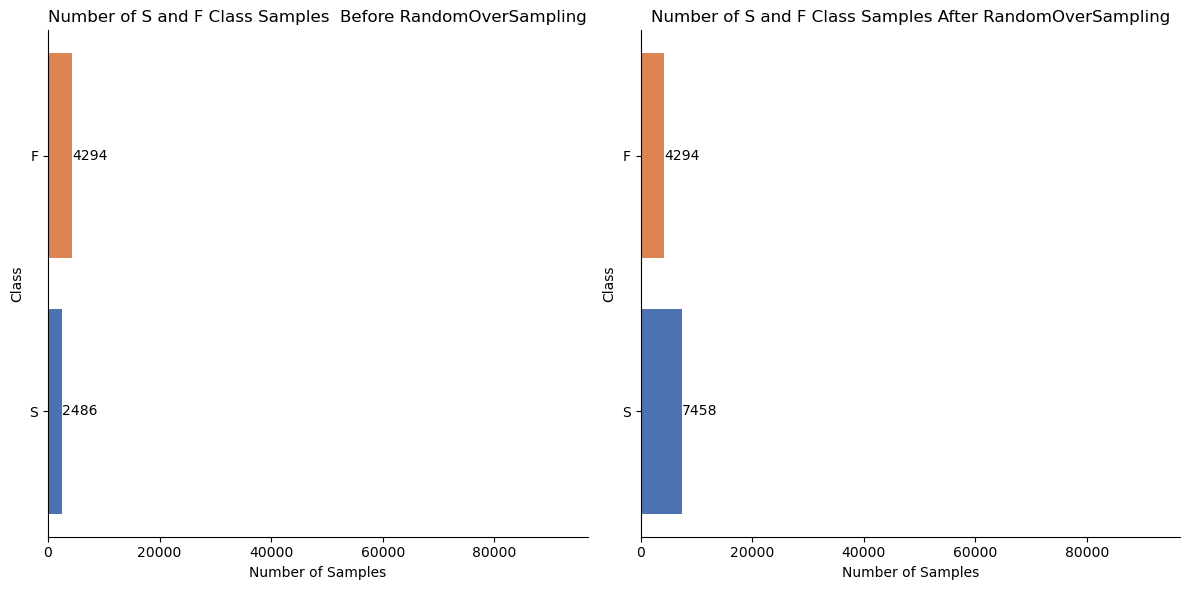

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the variables defined as follows
num_seg_n_before = 95696
num_seg_s_before = 2486
num_seg_v_before = 8347
num_seg_f_before = 512
num_seg_q_before = 4294

num_samples_before = [num_seg_n_before, num_seg_s_before, num_seg_v_before, num_seg_q_before, num_seg_f_before]

num_seg_n_after = 95696
num_seg_s_after = 7458
num_seg_v_after = 8347
num_seg_f_after = 1536
num_seg_q_after = 4294

num_samples_after = [num_seg_n_after, num_seg_s_after, num_seg_v_after, num_seg_q_after, num_seg_f_after]

# Modify the order of class labels
class_labels = ['N', 'S', 'V', 'F', 'Q']

# Filter only 'S' and 'F' classes
filtered_labels = ['S', 'F']
filtered_indices_before = [class_labels.index(label) for label in filtered_labels]
filtered_indices_after = [class_labels.index(label) for label in filtered_labels]

# Extract data for 'S' and 'F' classes
num_samples_filtered_before = [num_samples_before[i] for i in filtered_indices_before]
num_samples_filtered_after = [num_samples_after[i] for i in filtered_indices_after]
class_labels_filtered = [class_labels[i] for i in filtered_indices_before]

# Define a custom color palette
colors = sns.color_palette("deep")

# Plotting the horizontal bar chart with the filtered data and custom color palette
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotting before oversampling
axes[0].barh(class_labels_filtered, num_samples_filtered_before, color=colors)
axes[0].set_xlabel('Number of Samples')
axes[0].set_ylabel('Class')
axes[0].set_title('Number of S and F Class Samples  Before RandomOverSampling')
axes[0].set_xlim([0, max(num_samples_before) + 1000])

# Displaying the number of samples in front of each bar with increased boundaries
for index, value in enumerate(num_samples_filtered_before):
    axes[0].text(value + 5, index, str(value), ha='left', va='center')

# Plotting after oversampling
axes[1].barh(class_labels_filtered, num_samples_filtered_after, color=colors)
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Class')
axes[1].set_title('Number of S and F Class Samples After RandomOverSampling')
axes[1].set_xlim([0, max(num_samples_after) + 1000])

# Displaying the number of samples in front of each bar with increased boundaries
for index, value in enumerate(num_samples_filtered_after):
    axes[1].text(value + 5, index, str(value), ha='left', va='center')

# Remove spines (borders) from the plots
sns.despine()

plt.tight_layout()
plt.show()


In [29]:
print("Total Number of samples after synthesizing minority class:", Total)
print()
print("Number of samples for 'N' after synthesizing minority class:", num_seg_n)
print("Number of samples for 'S' after synthesizing minority class:", sum(y_resampled == 'S'))
print("Number of samples for 'V' after synthesizing minority class:", num_seg_v)
print("Number of samples for 'F' after synthesizing minority class:", sum(y_resampled == 'F'))
print("Number of samples for 'Q' after synthesizing minority class:", num_seg_q)

Total Number of samples after synthesizing minority class: 117331

Number of samples for 'N' after synthesizing minority class: 95696
Number of samples for 'S' after synthesizing minority class: 7458
Number of samples for 'V' after synthesizing minority class: 8347
Number of samples for 'F' after synthesizing minority class: 1536
Number of samples for 'Q' after synthesizing minority class: 4294


In [28]:
oversampler

RandomOverSampler(random_state=42, sampling_strategy={'F': 1536, 'S': 7458})

# Resampling using SMOTE

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X and y are your feature and target variables

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Specify the desired ratio for each class
sampling_strategy = {'S': 3*num_seg_s, 'F': 3*num_seg_f}

# Instantiate the SMOTE class with specified sampling_strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and transform the training data
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

In [48]:
df = pd.DataFrame(data=X_resampled_smote, columns=[f'value{i}' for i in range(1, X_resampled_smote.shape[1] + 1)])
df['label'] = y_resampled_smote

# Save the entire dataset to a CSV file
df.to_csv('final_smote.csv', index=False)

In [15]:
smote

SMOTE(random_state=42, sampling_strategy={'F': 1536, 'S': 7458})

In [22]:
len(X_resampled_smote)

84857

# Model

# Train

In [46]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_resampled_smote, y_resampled_smote)

SVC(kernel='linear', random_state=42)

# Validate

Validation Accuracy: 0.8739204545454545

Validation Classification Report:
               precision    recall  f1-score   support

           F       0.78      0.37      0.50       235
           N       0.88      0.98      0.93     14452
           Q       0.95      0.86      0.91       626
           S       0.72      0.39      0.50      1069
           V       0.65      0.15      0.24      1218

    accuracy                           0.87     17600
   macro avg       0.80      0.55      0.62     17600
weighted avg       0.86      0.87      0.85     17600


Validation Confusion Matrix:
 [[   86   149     0     0     0]
 [   19 14160    23   155    95]
 [    0    83   540     0     3]
 [    2   652     0   415     0]
 [    3  1024     4     7   180]]


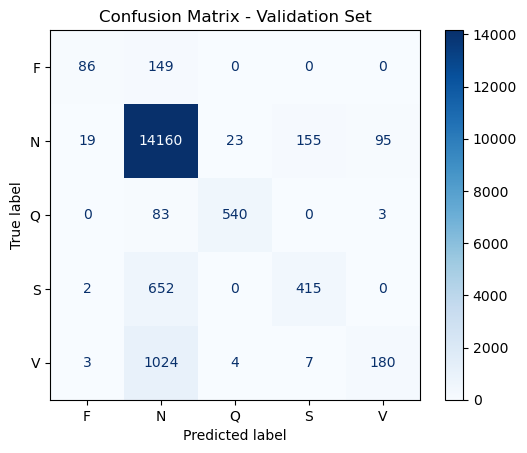

In [47]:
y_val_pred = svm_classifier.predict(X_val)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V']  

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Test


Test Accuracy: 0.8713068181818182

Test Classification Report:
               precision    recall  f1-score   support

           F       0.69      0.36      0.47       208
           N       0.88      0.98      0.93     14418
           Q       0.94      0.89      0.92       616
           S       0.74      0.35      0.47      1111
           V       0.64      0.17      0.27      1247

    accuracy                           0.87     17600
   macro avg       0.78      0.55      0.61     17600
weighted avg       0.85      0.87      0.85     17600


Test Confusion Matrix:
 [[   74   134     0     0     0]
 [   20 14113    35   132   118]
 [    0    65   549     0     2]
 [    1   722     0   388     0]
 [   13  1016     0     7   211]]


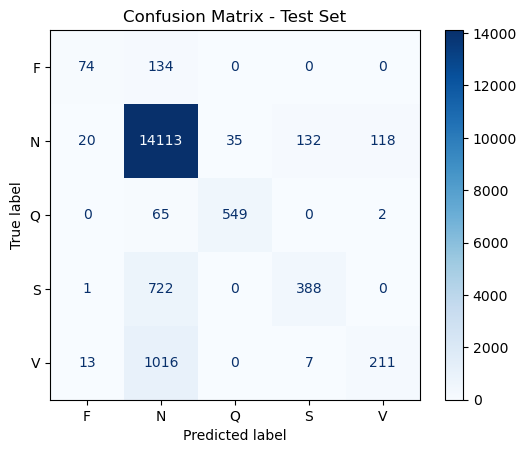

In [48]:
# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Display result statistics for the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V'] 

# Plot confusion matrix for the test set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),
                               display_labels=unique_labels)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()


# XGBOOST

In [4]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are your training, validation, and test sets

# Check the unique values of y_train
print("Unique values in y_train:", np.unique(y_resampled_smote))

# Encode string labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_resampled_smote)

# Check the number of unique classes in y_train
num_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in y_train:", num_classes)

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)
xgb_classifier.fit(X_resampled_smote, y_train_encoded)

# Make predictions on the validation set
y_val_pred_encoded = xgb_classifier.predict(X_val)

# Inverse transform to get original labels for comparison
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = np.unique(y_val)

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Make predictions on the test set
y_test_pred_encoded = xgb_classifier.predict(X_test)

# Inverse transform to get original labels for comparison
y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

# Display result statistics for the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Get unique class labels from your data
unique_labels = np.unique(y_test)

# Plot confusion matrix for the test set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),
                               display_labels=unique_labels)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


NameError: name 'y_resampled_smote' is not defined

# Data preparation

# Without sampling

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [30]:
print("Number of samples in training set for original dataset:", len(X_train))
print("Number of samples in validation set for original dataset:", len(X_val))
print("Number of samples in test set for original dataset:", len(X_test))

Number of samples in training set for original dataset: 77934
Number of samples in validation set for original dataset: 16700
Number of samples in test set for original dataset: 16701


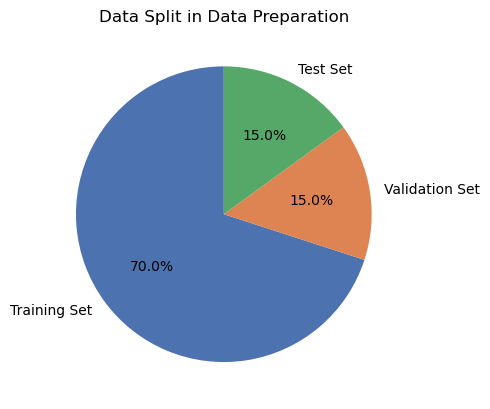

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the variables defined as follows
num_samples_train_resampled = len(X_train)
num_samples_val_resampled = len(X_val)
num_samples_test_resampled = len(X_test)

# Data for the pie chart
sizes_resampled = [num_samples_train_resampled, num_samples_val_resampled, num_samples_test_resampled]
labels_resampled = ['Training Set', 'Validation Set', 'Test Set']

# Define a muted color palette
colors_resampled = sns.color_palette("deep")

# Plotting the pie chart for resampled data with muted colors
plt.pie(sizes_resampled, labels=labels_resampled, autopct='%1.1f%%', colors=colors_resampled, startangle=90)
plt.title('Data Split in Data Preparation')
plt.show()

In [32]:
X_train_df = pd.DataFrame(X_train, columns=[f'value{i+1}' for i in range(X_train.shape[1])])
y_train_df = pd.DataFrame(y_train, columns=['label'])

X_val_df = pd.DataFrame(X_val, columns=[f'value{i+1}' for i in range(X_val.shape[1])])
y_val_df = pd.DataFrame(y_val, columns=['label'])

X_test_df = pd.DataFrame(X_test, columns=[f'value{i+1}' for i in range(X_test.shape[1])])
y_test_df = pd.DataFrame(y_test, columns=['label'])

# Display samples from the training set
train_samples = pd.concat([X_train_df, y_train_df], axis=1).sample(5)
print("Training Set Samples for Original data split:")
print(train_samples)

# Display samples from the validation set
val_samples = pd.concat([X_val_df, y_val_df], axis=1).sample(5)
print("\nValidation Set Samples Original data split:")
print(val_samples)

test_samples = pd.concat([X_test_df, y_test_df], axis=1).sample(5)
print("\nTesting Set Samples Original data split:")
print(test_samples)


Training Set Samples for Original data split:
         value1    value2    value3    value4    value5    value6    value7  \
1950   0.622819  0.620134  0.620134  0.614765  0.613423  0.610738  0.606711   
68894  0.552991  0.554701  0.554701  0.556410  0.555556  0.555556  0.558974   
24763  0.470539  0.468855  0.468013  0.466330  0.463805  0.465488  0.465488   
32959  0.571296  0.568519  0.567593  0.570370  0.570370  0.572222  0.573148   
9773   0.426401  0.427350  0.432099  0.436847  0.438746  0.440646  0.441595   

         value8    value9   value10  ...  value192  value193  value194  \
1950   0.604027  0.610738  0.612081  ...  0.710067  0.719463  0.718121   
68894  0.561538  0.559829  0.558120  ...  0.579487  0.579487  0.579487   
24763  0.466330  0.468013  0.468855  ...  0.414983  0.419192  0.422559   
32959  0.572222  0.572222  0.575926  ...  0.582407  0.584259  0.584259   
9773   0.436847  0.436847  0.437797  ...  0.474834  0.475783  0.476733   

       value195  value196  value19

# Model

# SVM

# Train

In [33]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

# Validate

Validation Accuracy: 0.8946706586826347

Validation Classification Report:
               precision    recall  f1-score   support

           F       0.00      0.00      0.00        73
           N       0.90      0.99      0.94     14345
           Q       0.96      0.87      0.91       645
           S       0.00      0.00      0.00       396
           V       0.60      0.14      0.23      1241

    accuracy                           0.89     16700
   macro avg       0.49      0.40      0.42     16700
weighted avg       0.85      0.89      0.86     16700


Validation Confusion Matrix:
 [[    0    73     0     0     0]
 [    0 14206    26     0   113]
 [    0    84   559     0     2]
 [    0   396     0     0     0]
 [    0  1065     0     0   176]]


/Users/sowmyavinay/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sowmyavinay/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sowmyavinay/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


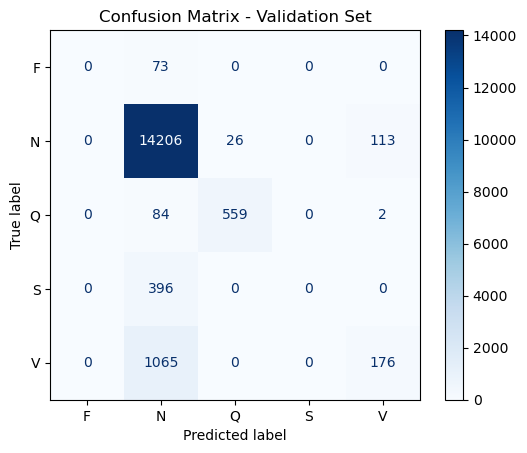

In [34]:
y_val_pred = svm_classifier.predict(X_val)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V']  

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Test


Test Accuracy: 0.8952757319920963

Test Classification Report:
               precision    recall  f1-score   support

           F       0.00      0.00      0.00        90
           N       0.90      0.99      0.94     14374
           Q       0.94      0.84      0.89       621
           S       0.00      0.00      0.00       368
           V       0.62      0.16      0.25      1248

    accuracy                           0.90     16701
   macro avg       0.49      0.40      0.42     16701
weighted avg       0.86      0.90      0.86     16701


Test Confusion Matrix:
 [[    0    90     0     0     0]
 [    0 14231    30     0   113]
 [    0    89   524     0     8]
 [    0   368     0     0     0]
 [    0  1049     2     0   197]]


/Users/sowmyavinay/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sowmyavinay/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sowmyavinay/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


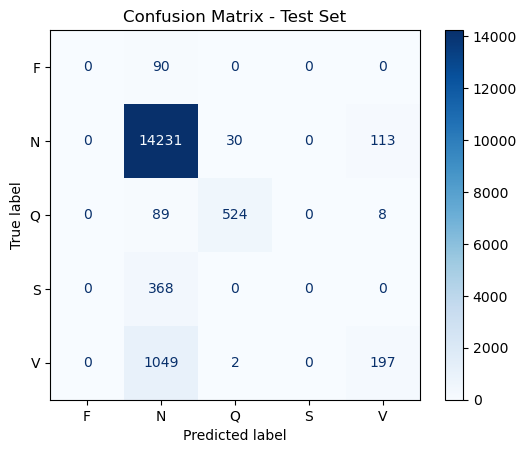

In [35]:
# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Display result statistics for the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V'] 

# Plot confusion matrix for the test set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),
                               display_labels=unique_labels)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()

# XGBoost

Unique values in y_train: ['F' 'N' 'Q' 'S' 'V']
Number of unique classes in y_train: 5
Validation Accuracy: 0.9269461077844311

Validation Classification Report:
               precision    recall  f1-score   support

           F       0.45      0.27      0.34        73
           N       0.94      0.98      0.96     14345
           Q       0.95      0.90      0.92       645
           S       0.64      0.31      0.42       396
           V       0.76      0.58      0.66      1241

    accuracy                           0.93     16700
   macro avg       0.75      0.61      0.66     16700
weighted avg       0.92      0.93      0.92     16700


Validation Confusion Matrix:
 [[   20    49     0     0     4]
 [   17 14032    29    64   203]
 [    0    44   581     0    20]
 [    0   268     0   122     6]
 [    7   502     2     5   725]]


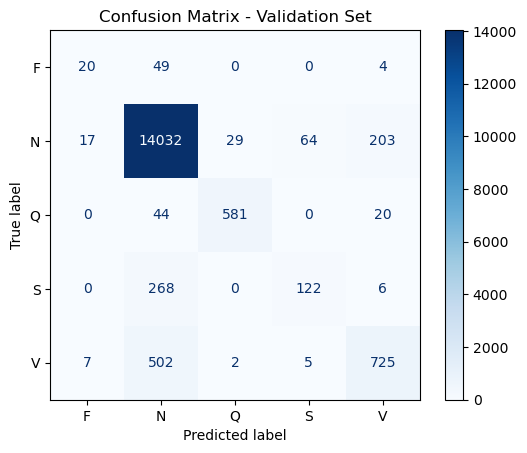


Test Accuracy: 0.9267109753906951

Test Classification Report:
               precision    recall  f1-score   support

           F       0.68      0.40      0.50        90
           N       0.94      0.98      0.96     14374
           Q       0.94      0.89      0.92       621
           S       0.51      0.23      0.32       368
           V       0.77      0.58      0.66      1248

    accuracy                           0.93     16701
   macro avg       0.77      0.62      0.67     16701
weighted avg       0.92      0.93      0.92     16701


Test Confusion Matrix:
 [[   36    48     0     0     6]
 [   10 14073    30    78   183]
 [    0    47   554     0    20]
 [    0   274     0    86     8]
 [    7   504     4     5   728]]


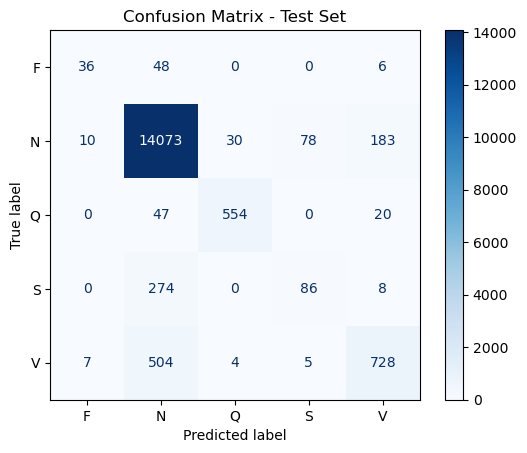

ValueError: multiclass format is not supported

In [7]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are your training, validation, and test sets

# Check the unique values of y_train
print("Unique values in y_train:", np.unique(y_train))

# Encode string labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Check the number of unique classes in y_train
num_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in y_train:", num_classes)

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions on the validation set
y_val_pred_encoded = xgb_classifier.predict(X_val)

# Inverse transform to get original labels for comparison
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = np.unique(y_val)

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Make predictions on the test set
y_test_pred_encoded = xgb_classifier.predict(X_test)

# Inverse transform to get original labels for comparison
y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

# Display result statistics for the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Get unique class labels from your data
unique_labels = np.unique(y_test)

# Plot confusion matrix for the test set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),
                               display_labels=unique_labels)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()



from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are your training, validation, and test sets

# Encode string labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Define the Transformer model
def transformer_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.MultiHeadAttention(num_heads=2, key_dim=2, dropout=0.1, use_bias=False, input_shape=input_shape))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Get input shape based on the number of features in X
input_shape = (X_train.shape[1],)

# Build and compile the model
model = transformer_model(input_shape, num_classes=len(np.unique(y_train_encoded)))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val, y_val_encoded))

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print("\nTest Accuracy:", test_accuracy)

# Make predictions on the test set
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)

# Display result statistics for the test set
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_labels))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_labels))


# With over sampling

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [40]:
print("Number of samples in training set for resampled data:", len(X_train))
print("Number of samples in validation set for resampled data:", len(X_val))
print("Number of samples in test set for resampled data:", len(X_test))

Number of samples in training set for resampled data: 82131
Number of samples in validation set for resampled data: 17600
Number of samples in test set for resampled data: 17600


In [41]:
# Convert NumPy arrays to Pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=[f'value{i+1}' for i in range(X_train.shape[1])])
y_train_df = pd.DataFrame(y_train, columns=['label'])

X_val_df = pd.DataFrame(X_val, columns=[f'value{i+1}' for i in range(X_val.shape[1])])
y_val_df = pd.DataFrame(y_val, columns=['label'])

X_test_df = pd.DataFrame(X_test, columns=[f'value{i+1}' for i in range(X_test.shape[1])])
y_test_df = pd.DataFrame(y_test, columns=['label'])

# Display samples from the training set
train_samples = pd.concat([X_train_df, y_train_df], axis=1).sample(5)
print("Training Set Samples for Resampled data split:")
print(train_samples)

# Display samples from the validation set
val_samples = pd.concat([X_val_df, y_val_df], axis=1).sample(5)
print("\nValidation Set Samples Resampled data split:")
print(val_samples)

test_samples = pd.concat([X_test_df, y_test_df], axis=1).sample(5)
print("\nTesting Set Samples Resampled data split:")
print(test_samples)



Training Set Samples for Resampled data split:
         value1    value2    value3    value4    value5    value6    value7  \
36551  0.449481  0.448536  0.447592  0.444759  0.443815  0.441926  0.441926   
71504  0.511541  0.513031  0.513031  0.510797  0.510797  0.511541  0.513031   
17631  0.507818  0.507818  0.509308  0.510052  0.508563  0.507818  0.510052   
77346  0.458702  0.457965  0.457965  0.463127  0.469027  0.475664  0.477139   
70888  0.476420  0.475457  0.479307  0.484119  0.484119  0.483157  0.482194   

         value8    value9   value10  ...  value192  value193  value194  \
36551  0.442871  0.442871  0.444759  ...  0.449481  0.450425  0.453258   
71504  0.513031  0.512286  0.510797  ...  0.521221  0.524944  0.524944   
17631  0.510052  0.510797  0.509308  ...  0.511541  0.512286  0.518243   
77346  0.477139  0.471976  0.469764  ...  0.504425  0.504425  0.507375   
70888  0.483157  0.485082  0.488932  ...  0.555342  0.552454  0.553417   

       value195  value196  value1

# Model

# SVM

# Train

In [42]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

# Validate

Validation Accuracy: 0.8738068181818182

Validation Classification Report:
               precision    recall  f1-score   support

           F       0.79      0.35      0.48       235
           N       0.88      0.98      0.93     14452
           Q       0.95      0.86      0.91       626
           S       0.73      0.38      0.50      1069
           V       0.65      0.15      0.24      1218

    accuracy                           0.87     17600
   macro avg       0.80      0.54      0.61     17600
weighted avg       0.86      0.87      0.85     17600


Validation Confusion Matrix:
 [[   82   153     0     0     0]
 [   17 14169    22   148    96]
 [    0    83   540     1     2]
 [    2   659     0   408     0]
 [    3  1025     5     5   180]]


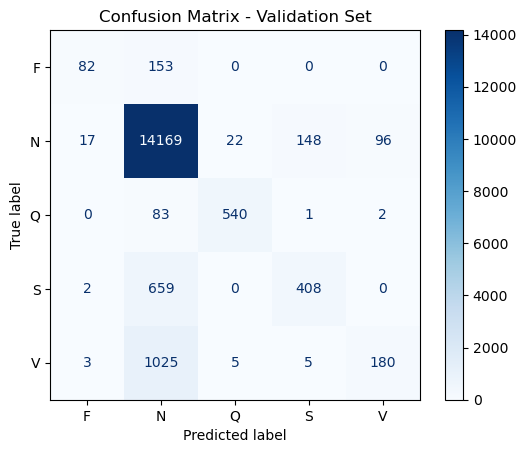

In [43]:
y_val_pred = svm_classifier.predict(X_val)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V']  

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Test


Test Accuracy: 0.8710227272727272

Test Classification Report:
               precision    recall  f1-score   support

           F       0.67      0.31      0.43       208
           N       0.88      0.98      0.93     14418
           Q       0.94      0.89      0.92       616
           S       0.75      0.34      0.47      1111
           V       0.64      0.17      0.27      1247

    accuracy                           0.87     17600
   macro avg       0.77      0.54      0.60     17600
weighted avg       0.85      0.87      0.84     17600


Test Confusion Matrix:
 [[   65   143     0     0     0]
 [   18 14124    35   123   118]
 [    0    65   549     0     2]
 [    1   727     0   383     0]
 [   13  1021     0     4   209]]


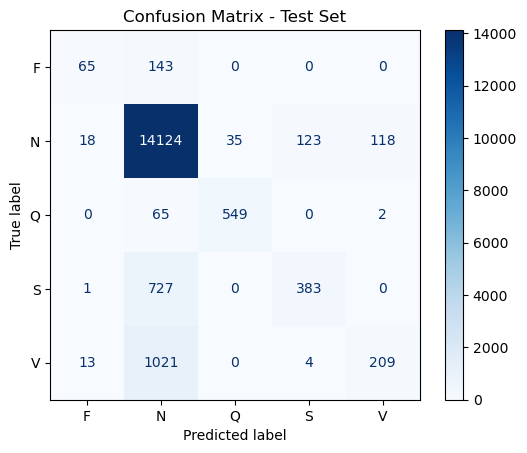

In [44]:
# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Display result statistics for the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V'] 

# Plot confusion matrix for the test set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),
                               display_labels=unique_labels)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()


# XGBoost

Unique values in y_train: ['F' 'N' 'Q' 'S' 'V']
Number of unique classes in y_train: 5
Validation Accuracy: 0.9340909090909091

Validation Classification Report:
               precision    recall  f1-score   support

           F       0.92      0.91      0.92       235
           N       0.95      0.97      0.96     14452
           Q       0.94      0.89      0.91       626
           S       0.86      0.83      0.84      1069
           V       0.77      0.57      0.66      1218

    accuracy                           0.93     17600
   macro avg       0.89      0.84      0.86     17600
weighted avg       0.93      0.93      0.93     17600


Validation Confusion Matrix:
 [[  215    15     0     0     5]
 [   17 14086    23   136   190]
 [    0    54   555     0    17]
 [    0   183     0   885     1]
 [    2   490    13    14   699]]


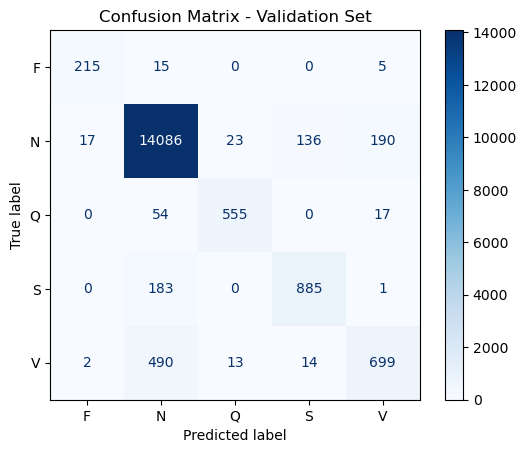


Test Accuracy: 0.9341477272727273

Test Classification Report:
               precision    recall  f1-score   support

           F       0.89      0.94      0.92       208
           N       0.95      0.97      0.96     14418
           Q       0.93      0.90      0.92       616
           S       0.86      0.80      0.83      1111
           V       0.79      0.60      0.68      1247

    accuracy                           0.93     17600
   macro avg       0.88      0.84      0.86     17600
weighted avg       0.93      0.93      0.93     17600


Test Confusion Matrix:
 [[  195    11     0     0     2]
 [   14 14053    38   129   184]
 [    0    44   557     1    14]
 [    0   219     0   892     0]
 [    9   475     4    15   744]]


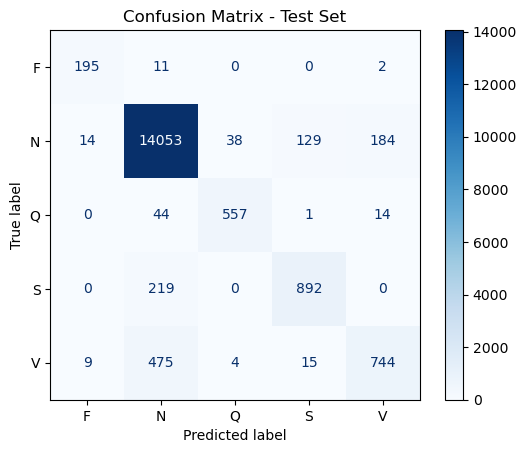

In [40]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the unique values of y_train
print("Unique values in y_train:", np.unique(y_train))

# Encode string labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Check the number of unique classes in y_train
num_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in y_train:", num_classes)

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)
xgb_classifier.fit(X_train, y_train_encoded)

# Make predictions on the validation set
y_val_pred_encoded = xgb_classifier.predict(X_val)

# Inverse transform to get original labels for comparison
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = np.unique(y_val)

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Make predictions on the test set
y_test_pred_encoded = xgb_classifier.predict(X_test)

# Inverse transform to get original labels for comparison
y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

# Display result statistics for the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Get unique class labels from your data
unique_labels = np.unique(y_test)

# Plot confusion matrix for the test set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),
                               display_labels=unique_labels)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()


# Cross Validation K - Folds

In [167]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Assuming X_train and X_val are NumPy arrays
X_train_df = pd.DataFrame(X_train)  # No need to specify columns if they are just numerical indices
X_val_df = pd.DataFrame(X_val)

# Concatenate X_train_df and X_val_df to create a new X_combined
X_combined = pd.concat([X_train_df, X_val_df], axis=0)

# Assuming y_train and y_val are also NumPy arrays
y_train_series = pd.Series(y_train, name='target')
y_val_series = pd.Series(y_val, name='target')

# Concatenate y_train_series and y_val_series to create a new y_combined
y_combined = pd.concat([y_train_series, y_val_series], axis=0)

# Specify the number of splits (K=5)
n_splits = 5

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_combined, y_combined), start=1):
    # Create training and validation sets for this fold
    X_train_fold, X_val_fold = X_combined.iloc[train_index], X_combined.iloc[val_index]
    y_train_fold, y_val_fold = y_combined.iloc[train_index], y_combined.iloc[val_index]

    # You can use X_train_fold, X_val_fold, y_train_fold, y_val_fold for training and validation for this fold
    # ...

    print(f"\nFold {fold}:")
    print("Training set size:", len(X_train_fold))
    print("Validation set size:", len(X_val_fold))



Fold 1:
Training set size: 79784
Validation set size: 19947

Fold 2:
Training set size: 79785
Validation set size: 19946

Fold 3:
Training set size: 79785
Validation set size: 19946

Fold 4:
Training set size: 79785
Validation set size: 19946

Fold 5:
Training set size: 79785
Validation set size: 19946


In [92]:
# Combine the training and validation sets
X_train_val = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(X_temp)])
y_train_val = pd.concat([pd.Series(y_resampled), pd.Series(y_temp)])

# Define the number of folds
n_splits = 5  # Adjust as needed

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over folds
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train_val, y_train_val)):
    X_fold_train, X_fold_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_fold_train, y_fold_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]


In [162]:
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train_val, y_train_val)):
    X_fold_train, X_fold_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_fold_train, y_fold_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    print(len(X_fold_train))
    print(len(X_fold_val))

120585
30147
120585
30147
120586
30146
120586
30146
120586
30146


In [160]:
print(len(X_fold_train))

120586


In [157]:
from sklearn.model_selection import StratifiedKFold

# Assuming X_resampled and y_resampled are your feature and target variables after SMOTE

# Combine the training and validation sets
X_train_val = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(X_temp)])
y_train_val = pd.concat([pd.Series(y_resampled), pd.Series(y_temp)])

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store class distribution for each fold
class_distribution_before = []
class_distribution_after = []

# Print class distribution before StratifiedKFold
print("Class distribution before StratifiedKFold:")
print(y_train_val.value_counts())

# Iterate over folds
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train_val, y_train_val)):
    X_fold_train, X_fold_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_fold_train, y_fold_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Append class distribution to lists
    class_distribution_before.append(y_fold_train.value_counts())
    class_distribution_after.append(y_fold_val.value_counts())

# Print class distribution after each fold
for fold, (before, after) in enumerate(zip(class_distribution_before, class_distribution_after)):
    print(f"\nClass distribution after Fold {fold + 1}:")
    print("Training Split:")
    print(before)
    print("Validate Split:")
    print(after)
    print("-" * 30)


Class distribution before StratifiedKFold:
N    124415
V     10836
S      8222
Q      5560
F      1699
dtype: int64

Class distribution after Fold 1:
Training Split:
N    99532
V     8669
S     6577
Q     4448
F     1359
dtype: int64
Validate Split:
N    24883
V     2167
S     1645
Q     1112
F      340
dtype: int64
------------------------------

Class distribution after Fold 2:
Training Split:
N    99532
V     8669
S     6577
Q     4448
F     1359
dtype: int64
Validate Split:
N    24883
V     2167
S     1645
Q     1112
F      340
dtype: int64
------------------------------

Class distribution after Fold 3:
Training Split:
N    99532
V     8668
S     6578
Q     4448
F     1360
dtype: int64
Validate Split:
N    24883
V     2168
S     1644
Q     1112
F      339
dtype: int64
------------------------------

Class distribution after Fold 4:
Training Split:
N    99532
V     8669
S     6578
Q     4448
F     1359
dtype: int64
Validate Split:
N    24883
V     2167
S     1644
Q     1112
F      

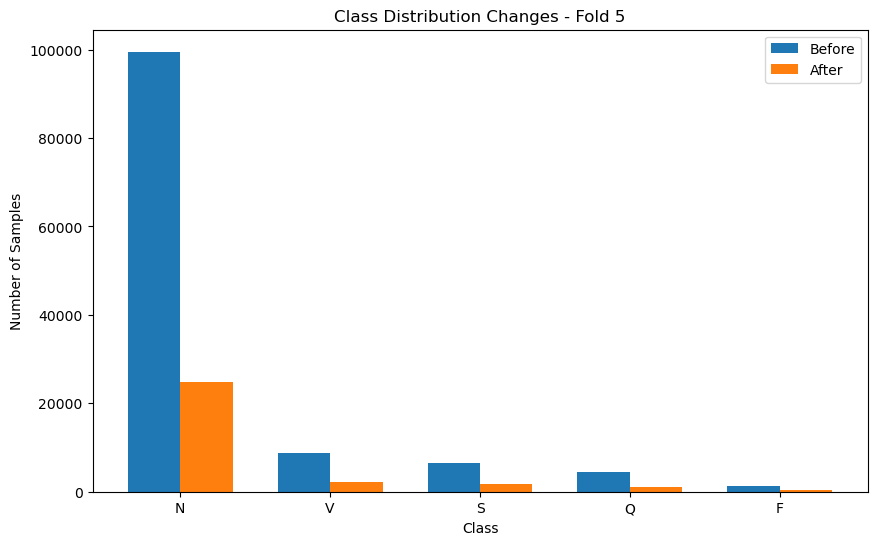

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming class_distribution_before and class_distribution_after are your lists of Series

# Extracting data for Fold 5
fold_index = 4  # 0-based index for the fifth fold
before_fold_5 = class_distribution_before[fold_index]
after_fold_5 = class_distribution_after[fold_index]

# Plotting class distribution changes for Fold 5
fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
classes = np.arange(len(before_fold_5.index))
width = 0.35

ax.bar(classes - width/2, before_fold_5, width, label='Before')
ax.bar(classes + width/2, after_fold_5, width, label='After')

ax.set_xticks(classes)
ax.set_xticklabels(before_fold_5.index)
ax.set_title('Class Distribution Changes - Fold 5')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Samples')
ax.legend()

plt.show()


# Model

# Without Sampling

# Training

# Training

In [50]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

Validation Accuracy: 0.8677406635498226

Validation Classification Report:
               precision    recall  f1-score   support

           F       0.83      0.43      0.56       415
           N       0.88      0.98      0.92     14427
           Q       0.94      0.86      0.90       626
           S       0.72      0.36      0.48      1078
           V       0.61      0.16      0.25      1207

    accuracy                           0.87     17753
   macro avg       0.80      0.56      0.62     17753
weighted avg       0.85      0.87      0.84     17753


Validation Confusion Matrix:
 [[  177   238     0     0     0]
 [   19 14112    31   146   119]
 [    1    86   539     0     0]
 [    1   690     0   387     0]
 [   14   998     2     3   190]]

Test Accuracy: 0.8689872704742593

Test Classification Report:
               precision    recall  f1-score   support

           F       0.79      0.41      0.54       382
           N       0.87      0.98      0.92     14410
          

# Validating

Validation Accuracy: 0.8968263473053892

Validation Classification Report:
               precision    recall  f1-score   support

           F       0.48      0.41      0.44        73
           N       0.91      0.98      0.94     14345
           Q       0.95      0.87      0.91       645
           S       0.53      0.43      0.48       396
           V       0.61      0.14      0.23      1241

    accuracy                           0.90     16700
   macro avg       0.70      0.57      0.60     16700
weighted avg       0.88      0.90      0.88     16700


Validation Confusion Matrix:
 [[   30    43     0     0     0]
 [   20 14041    27   146   111]
 [    0    86   558     1     0]
 [    0   224     0   172     0]
 [   12  1049     0     4   176]]


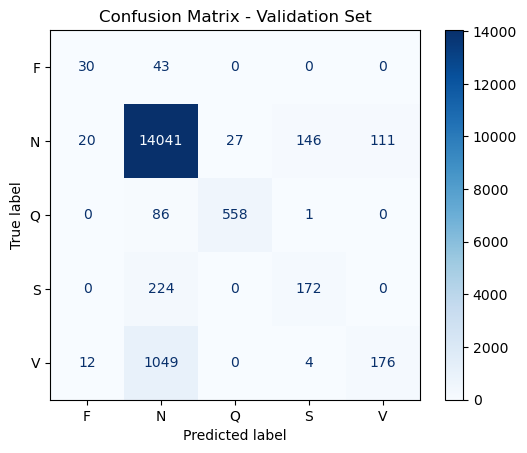

In [63]:
y_val_pred = svm_classifier.predict(X_val)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V']  

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Testing


Test Accuracy: 0.895036225375726

Test Classification Report:
               precision    recall  f1-score   support

           F       0.48      0.36      0.41        90
           N       0.91      0.98      0.94     14374
           Q       0.94      0.85      0.89       621
           S       0.44      0.31      0.36       368
           V       0.64      0.16      0.25      1248

    accuracy                           0.90     16701
   macro avg       0.68      0.53      0.57     16701
weighted avg       0.88      0.90      0.87     16701


Test Confusion Matrix:
 [[   32    58     0     0     0]
 [   21 14079    30   137   107]
 [    0    89   526     0     6]
 [    0   254     0   114     0]
 [   13  1030     2     6   197]]


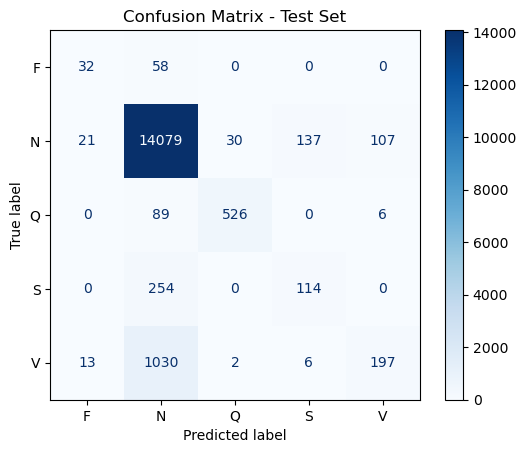

In [67]:
# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Display result statistics for the test set
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V'] 

# Plot confusion matrix for the test set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),
                               display_labels=unique_labels)  
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.show()


# SMOTE

In [15]:
# Initialize a list to store the data as (heartbeat, label) pairs
data_pairs = []

for category, heartbeats in aami_categories.items():
    for heartbeat in heartbeats:
        data_pairs.append((heartbeat, category))

In [16]:
import pandas as pd

# Assuming data_pairs contains your list of (heartbeat, label) pairs
original_data_frame = pd.DataFrame(data_pairs, columns=['Heartbeat', 'Label'])

In [19]:
# Assuming data_df contains your DataFrame with 'Heartbeat' and 'Label' columns

# Separate the features (X) and labels (y)
X = original_data_frame['Heartbeat'].tolist()
y = original_data_frame['Label'].tolist()

# Initialize SMOTE with 'auto' sampling strategy
smote = SMOTE(sampling_strategy='auto')

# Apply SMOTE to generate synthetic data points
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame for the balanced data
smote_data_df = pd.DataFrame({'Heartbeat': X_resampled, 'Label': y_resampled})

print("Total number of heartbeats: ", len(smote_data_df))

print("")

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_resampled))


# Now, balanced_data_df contains the data after applying SMOTE


Total number of heartbeats:  478480

Class distribution after SMOTE: Counter({'N': 95696, 'S': 95696, 'V': 95696, 'F': 95696, 'Q': 95696})


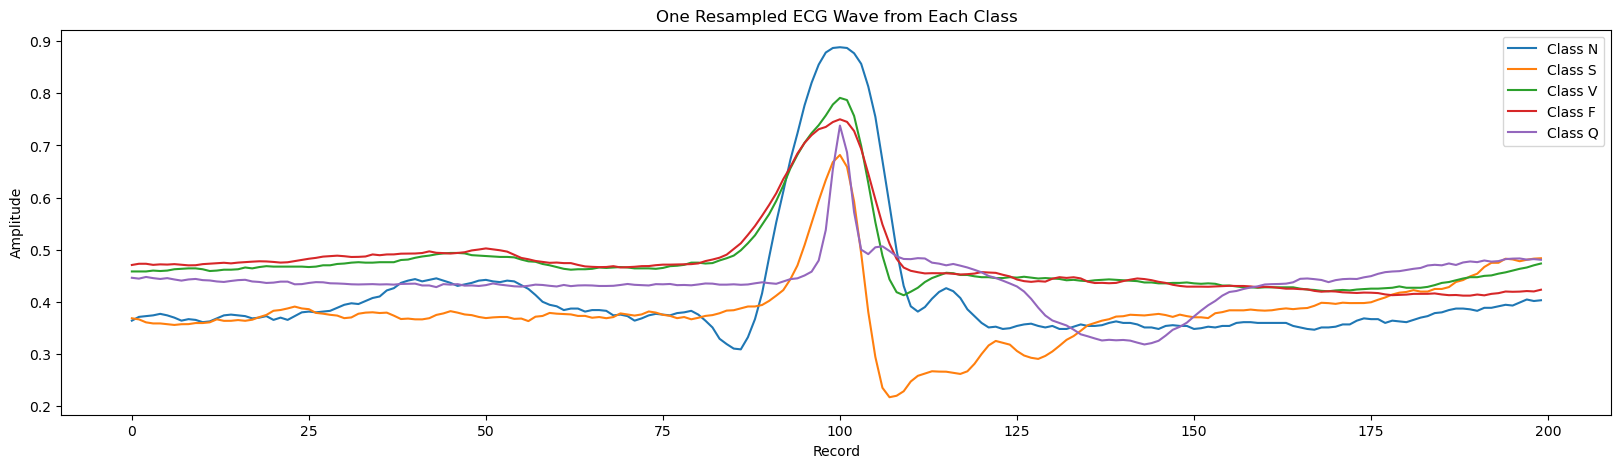

In [22]:
unique_labels = smote_data_df['Label'].unique()

# Initialize a dictionary to store one sample for each class
one_sample_per_class = {}

# Randomly select one sample for each class
for label in unique_labels:
    class_samples = smote_data_df[smote_data_df['Label'] == label]
    selected_sample = class_samples.sample(n=1)['Heartbeat'].values[0]
    one_sample_per_class[label] = selected_sample

# Plot the selected samples
plt.figure(figsize=(20, 5))

for label, sample in one_sample_per_class.items():
    plt.plot(sample, label=f'Class {label}')

plt.legend()
plt.xlabel('Record')
plt.ylabel('Amplitude')
plt.title('One Resampled ECG Wave from Each Class')
plt.show()


<Figure size 1200x600 with 0 Axes>

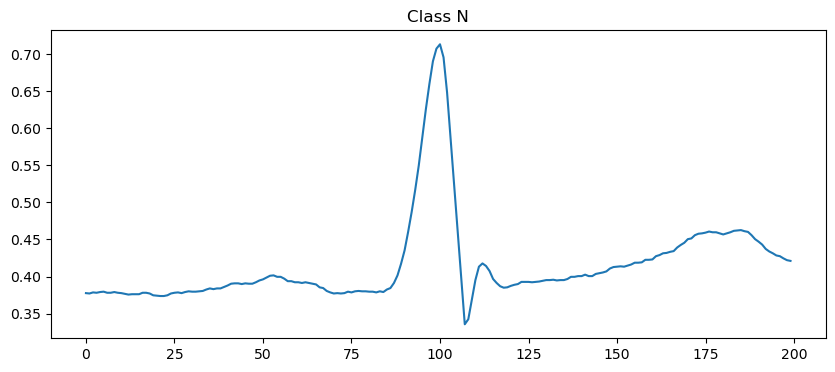

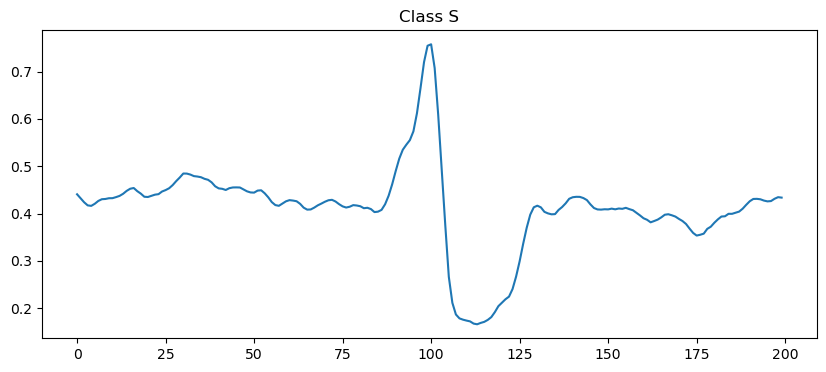

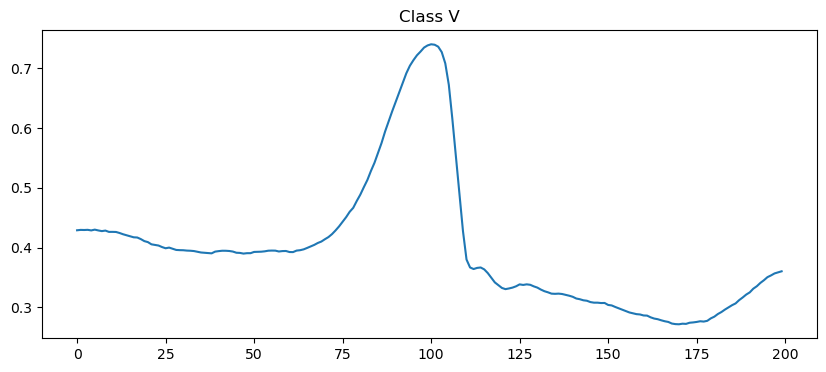

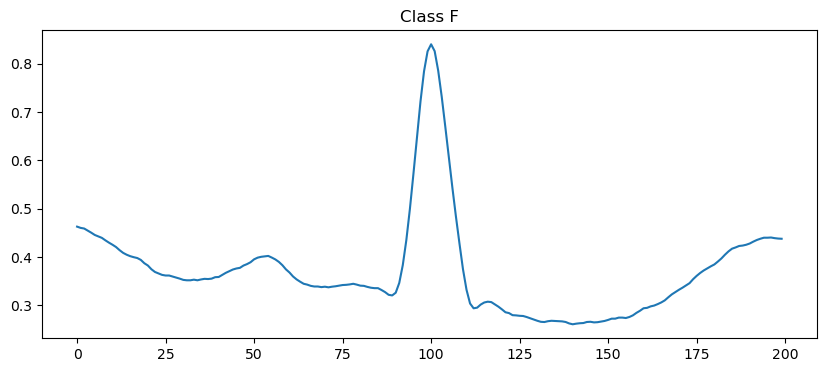

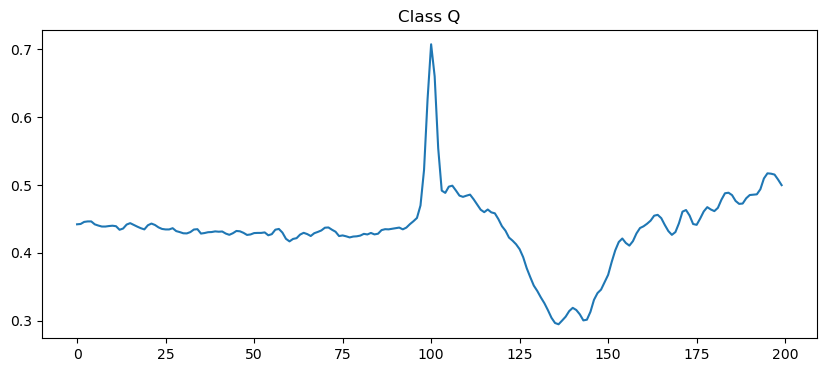

In [21]:
unique_labels = smote_data_df['Label'].unique()

# Initialize a dictionary to store one sample for each class
one_sample_per_class = {}

# Randomly select one sample for each class
for label in unique_labels:
    class_samples = smote_data_df[smote_data_df['Label'] == label]
    selected_sample = class_samples.sample(n=1)['Heartbeat'].values[0]
    one_sample_per_class[label] = selected_sample

# Plot the selected samples separately
plt.figure(figsize=(12, 6))

for label, sample in one_sample_per_class.items():
    plt.figure(figsize=(10, 4))
    plt.plot(sample)
    plt.title(f'Class {label}')
    plt.show()


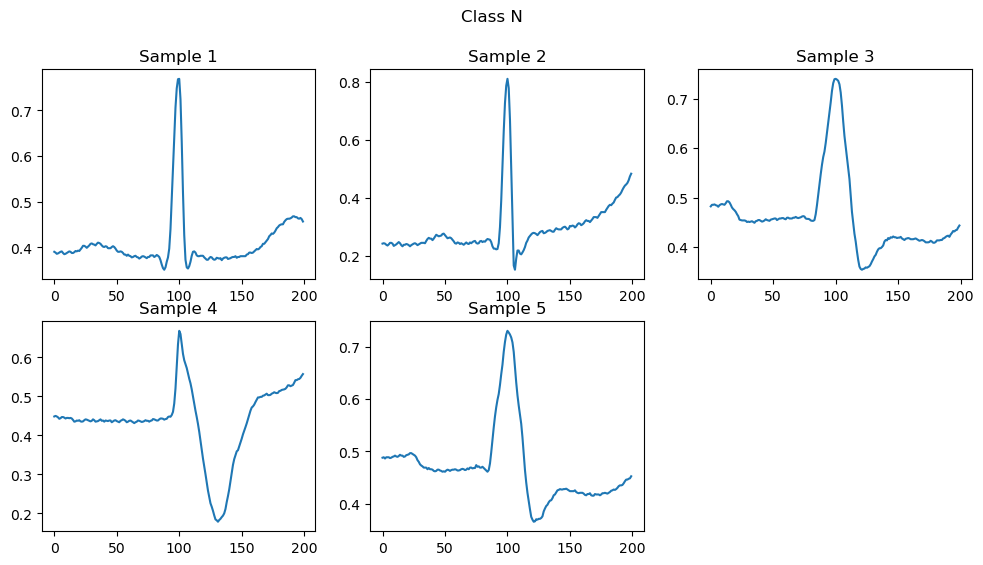

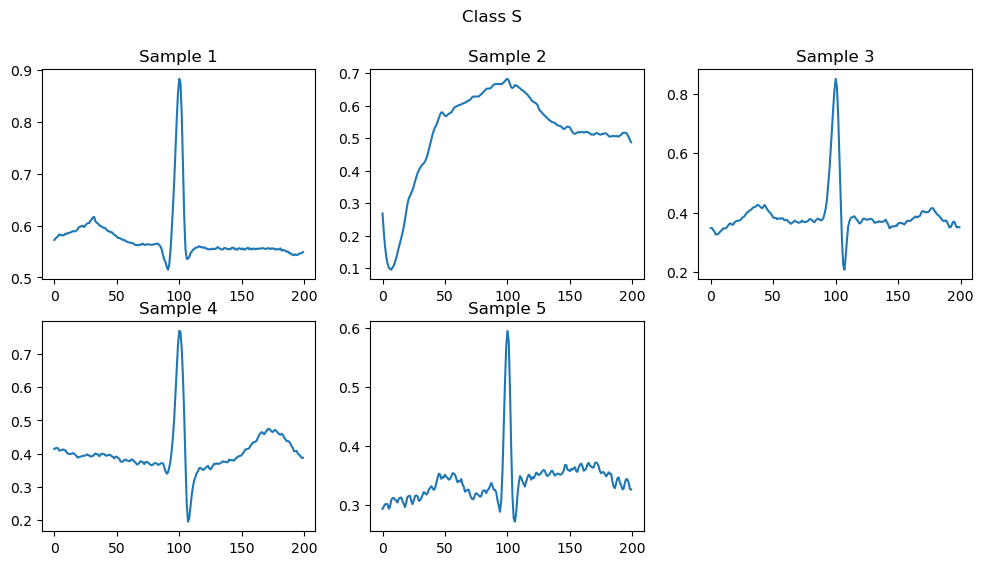

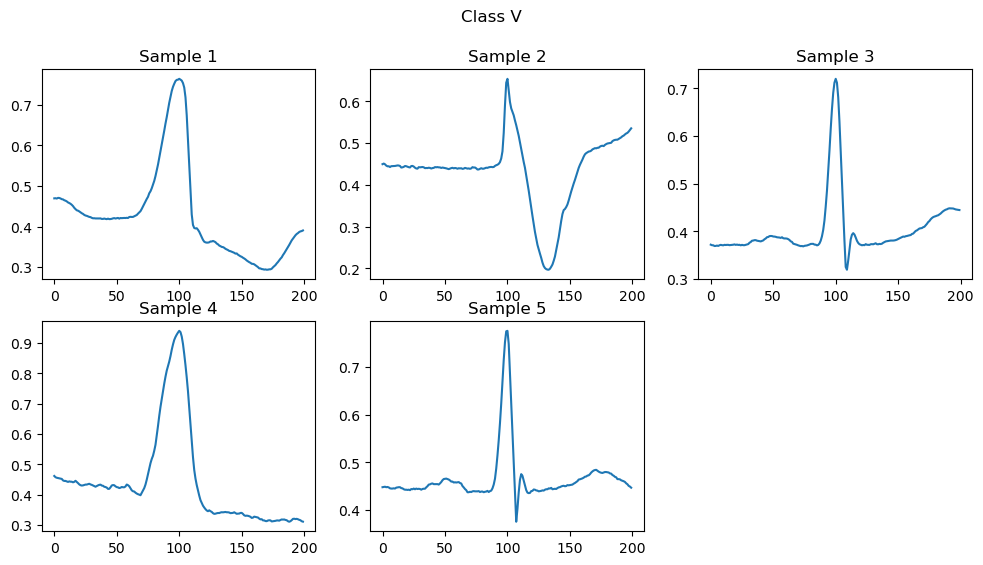

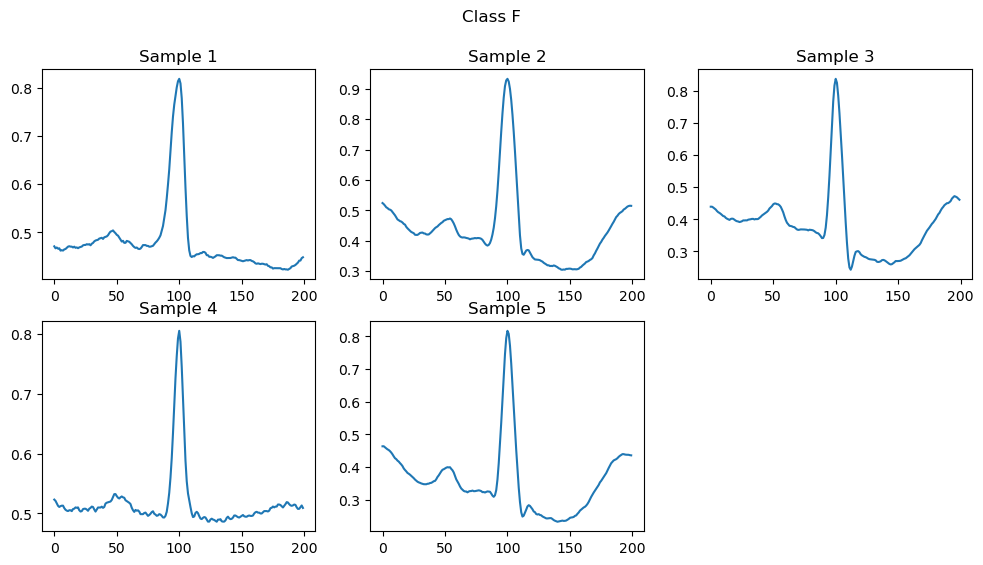

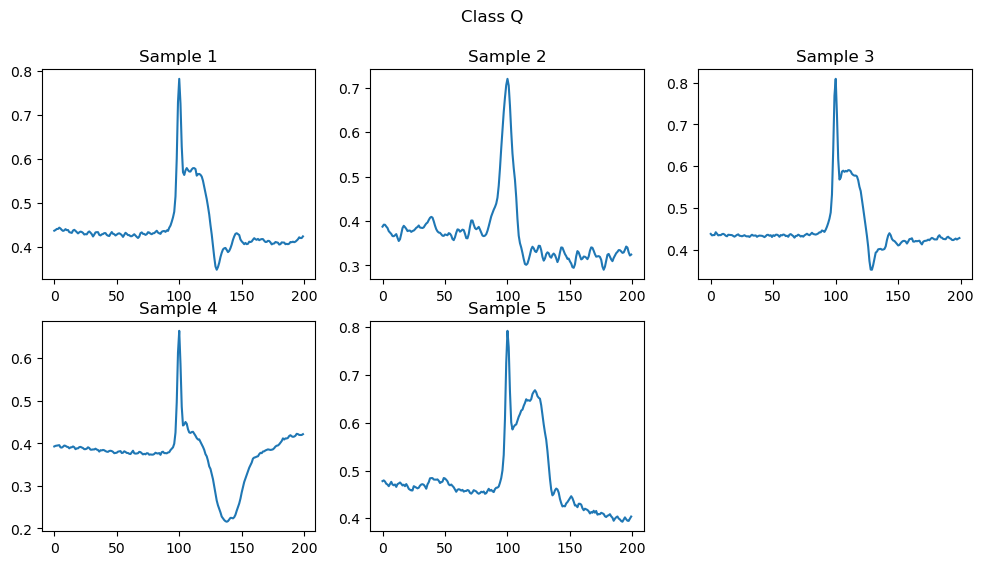

In [13]:
unique_labels = smote_data_df['Label'].unique()

# Initialize a dictionary to store 5 samples for each class
samples_per_class = {label: [] for label in unique_labels}

# Randomly select 5 samples for each class
for label in unique_labels:
    class_samples = smote_data_df[smote_data_df['Label'] == label]
    selected_samples = class_samples.sample(n=5)['Heartbeat'].values
    samples_per_class[label] = selected_samples

# Plot the selected samples separately
for label, samples in samples_per_class.items():
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Class {label}')
    for i, sample in enumerate(samples):
        plt.subplot(2, 3, i + 1)
        plt.plot(sample)
        plt.title(f'Sample {i+1}')
    plt.show()
